<a href="https://colab.research.google.com/github/AlexanderLontke/ssl-remote-sensing/blob/vae-segmentation/notebooks/Segmentation_DFC2020_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segmentation downstream task: DFC2020

Model: ResNetUnet \\
Data: DFC2020 \\
Pretrained weights: dependent on pretext tasks



### Environment setup

In [1]:
!pip install ssl_remote_sensing@git+https://github.com/AlexanderLontke/ssl-remote-sensing.git@vae-segmentation

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/AlexanderLontke/ssl-remote-sensing.git (to revision vae-segmentation) to /tmp/pip-install-9w7vmqdi/ssl-remote-sensing_72a722e8bd004886887a24a64d7c8acd
  Running command git clone -q https://github.com/AlexanderLontke/ssl-remote-sensing.git /tmp/pip-install-9w7vmqdi/ssl-remote-sensing_72a722e8bd004886887a24a64d7c8acd
  Running command git checkout -b vae-segmentation --track origin/vae-segmentation
  Switched to a new branch 'vae-segmentation'
  Branch 'vae-segmentation' set up to track remote branch 'vae-segmentation' from 'origin'.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 329 kB 31.7 MB/s 
     |████████████████████████████████| 20.9 MB 214 kB/s 
     |████████████████████████████████| 1.9 MB 7

In [3]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:
from ssl_remote_sensing.data.dfc2020 import DFC2020
from ssl_remote_sensing.downstream_tasks.segmentation.utils import patch_first_conv, get_metrics, visualize_result
from ssl_remote_sensing.downstream_tasks.segmentation.training import train
from ssl_remote_sensing.downstream_tasks.segmentation.model import ResNetUNet
from ssl_remote_sensing.pretext_tasks.vae.model import VariationalAutoencoder
from ssl_remote_sensing.pretext_tasks.vae.utils import reproducibility
from ssl_remote_sensing.constants import RANDOM_INITIALIZATION
from ssl_remote_sensing.pretext_tasks.utils import (
    load_encoder_checkpoint_from_pretext_model,
)

In [4]:
import rasterio
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import numpy as np
import torch 
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import os
import cv2
from albumentations.pytorch import ToTensorV2
import albumentations as A
import torch.nn as nn
import torch.nn.functional as F
import random
from tqdm import tqdm
from torchmetrics import JaccardIndex
from sklearn.metrics import confusion_matrix, accuracy_score, jaccard_score
import gdown
import tarfile

/usr/local/lib/python3.8/dist-packages/html5lib/_trie/_base.py:3: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping


In [6]:
import wandb
wandb.login()

wandb: Currently logged in as: xuemei-jiang. Use `wandb login --relogin` to force relogin


True

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
RANDOM_INITIALIZATION

'random'

In [24]:
g_drive_path = "/content/drive/MyDrive/deep_learning_checkpoints"
check_point_paths = os.listdir(g_drive_path)
check_point_paths += [RANDOM_INITIALIZATION]
check_point_paths = [g_drive_path + "/" + x for x in check_point_paths]
check_point_paths

['/content/drive/MyDrive/deep_learning_checkpoints/SimCLR_ResNet18_adam_bs2250-v1.ckpt',
 '/content/drive/MyDrive/deep_learning_checkpoints/vae.ckpt',
 '/content/drive/MyDrive/deep_learning_checkpoints/BiGAN_encoder_ckpt_100.ckpt',
 '/content/drive/MyDrive/deep_learning_checkpoints/random']

### Hyperparameter setup

In [30]:
# Model Setup
class Hparams:
    def __init__(self):
        self.epochs = 10 # number of training epochs for pretext tasks
        self.seed = 1234  # randomness seed
        self.gradient_accumulation_steps = 1  # gradient accumulation steps
        self.batch_size = 16
        self.lr = 1e-3
        self.weight_decay = 1e-6
        self.optim = "Adam"
        self.cuda = True  # use coda
        self.transform = False
        self.split = False
        self.frozen = True

In [31]:
train_config = Hparams()

In [32]:
reproducibility(train_config)

## Data

In [12]:
dfc2020_path = '/content/drive/MyDrive/dfc2020/dfc_2020.tar.gz'

In [13]:
with tarfile.open(dfc2020_path, mode="r") as tar:
    tar.extractall(path='/content/')

In [14]:
from torch.utils.data import random_split

In [15]:
dataset = DFC2020('/content/dfc_data', subset="test", use_s1=False, use_s2lr=True, use_s2hr=True,
                 use_s2mr=True, no_savanna=True)
trainset, valset = random_split(dataset, [4102, 1026])

[Load]: 100%|██████████| 5128/5128 [00:00<00:00, 473211.10it/s]

loaded 5128 samples from the dfc2020 subset test


id: ROIs0000_test_s2_0_p1150.tif 
 input shape: (13, 256, 256) 
 label shape: (256, 256) 



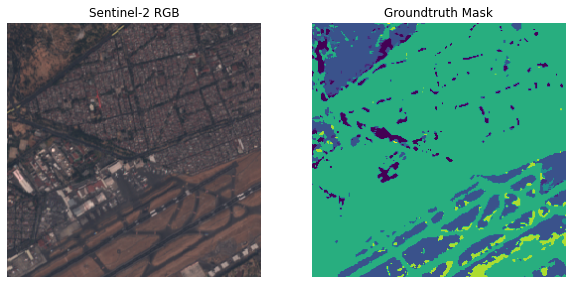

In [16]:
dataset.visualize_observation(170)

In [17]:
train_loader = DataLoader(trainset,
                          batch_size=8,
                          shuffle=True,
                          num_workers=1,
                          pin_memory=True,
                          drop_last=False)
val_loader = DataLoader(valset,
                          batch_size=8,
                          shuffle=True,
                          num_workers=1,
                          pin_memory=True,
                          drop_last=False)

In [18]:
next(iter(train_loader))["label"].shape

torch.Size([8, 256, 256])

## Segmentation Model

In [19]:
loss_fn = nn.CrossEntropyLoss(ignore_index=255, reduction='mean')

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


Validation Loss: 0.6964: 100%|██████████| 129/129 [00:15<00:00,  8.09it/s]

train_iou is 0.2839, val_iou is 0.3406
train_acc is 0.6784, val_acc is 0.7479



Validation Loss: 0.6221: 100%|██████████| 129/129 [00:15<00:00,  8.09it/s]


Saving Model...
train_iou is 0.3529, val_iou is 0.3781
train_acc is 0.7546, val_acc is 0.7782


Validation Loss: 0.5574: 100%|██████████| 129/129 [00:16<00:00,  8.05it/s]


Saving Model...
train_iou is 0.3785, val_iou is 0.4193
train_acc is 0.7743, val_acc is 0.8052


Validation Loss: 0.5468: 100%|██████████| 129/129 [00:15<00:00,  8.08it/s]


Saving Model...
train_iou is 0.3942, val_iou is 0.4208
train_acc is 0.7880, val_acc is 0.8074


Validation Loss: 0.5122: 100%|██████████| 129/129 [00:15<00:00,  8.12it/s]


Saving Model...
train_iou is 0.4017, val_iou is 0.4322
train_acc is 0.7927, val_acc is 0.8150


Validation Loss: 0.4758: 100%|██████████| 129/129 [00:15<00:00,  8.15it/s]


Saving Model...
train_iou is 0.4145, val_iou is 0.4314
train_acc is 0.8038, val_acc is 0.8278


Validation Loss: 0.4773: 100%|██████████| 129/129 [00:15<00:00,  8.13it/s]

train_iou is 0.4273, val_iou is 0.4387
train_acc is 0.8139, val_acc is 0.8255



Validation Loss: 0.4735: 100%|██████████| 129/129 [00:15<00:00,  8.14it/s]


Saving Model...
train_iou is 0.4320, val_iou is 0.4527
train_acc is 0.8177, val_acc is 0.8268


Validation Loss: 0.4327: 100%|██████████| 129/129 [00:15<00:00,  8.09it/s]


Saving Model...
train_iou is 0.4463, val_iou is 0.4701
train_acc is 0.8277, val_acc is 0.8437


Validation Loss: 0.4372: 100%|██████████| 129/129 [00:15<00:00,  8.09it/s]


train_iou is 0.4546, val_iou is 0.4805
train_acc is 0.8327, val_acc is 0.8420
Finished Training


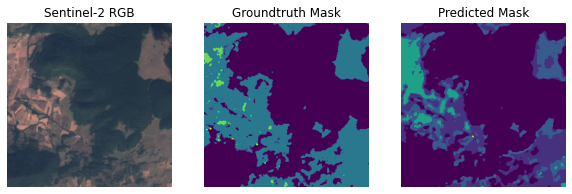

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


train_acc_segmentation,▁▄▅▆▆▇▇▇██
train_iou_segmentation,▁▄▅▆▆▆▇▇██
train_loss_segmentation,█▅▄▃▃▂▂▂▁▁
val_acc_segmentation,▁▃▅▅▆▇▇▇██
val_iou_segmentation,▁▃▅▅▆▆▆▇▇█
val_loss_segmentation,█▆▄▄▃▂▂▂▁▁
train_acc_segmentation,0.83274
train_iou_segmentation,0.45456
train_loss_segmentation,0.45486
val_acc_segmentation,0.84197
val_iou_segmentation,0.48054


Validation Loss: 23.5264: 100%|██████████| 129/129 [00:15<00:00,  8.15it/s]

train_iou is 0.2649, val_iou is 0.2719
train_acc is 0.6533, val_acc is 0.6385



Validation Loss: 5.6113: 100%|██████████| 129/129 [00:15<00:00,  8.16it/s]


Saving Model...
train_iou is 0.3352, val_iou is 0.3501
train_acc is 0.7388, val_acc is 0.7250


Validation Loss: 6.2057: 100%|██████████| 129/129 [00:15<00:00,  8.15it/s]

train_iou is 0.3572, val_iou is 0.3419
train_acc is 0.7582, val_acc is 0.7211



Validation Loss: 2.7124: 100%|██████████| 129/129 [00:15<00:00,  8.14it/s]


Saving Model...
train_iou is 0.3704, val_iou is 0.3630
train_acc is 0.7670, val_acc is 0.7552


Validation Loss: 3.8461: 100%|██████████| 129/129 [00:15<00:00,  8.16it/s]

train_iou is 0.3831, val_iou is 0.3699
train_acc is 0.7777, val_acc is 0.7665



Validation Loss: 5.7484: 100%|██████████| 129/129 [00:15<00:00,  8.16it/s]

train_iou is 0.3914, val_iou is 0.3707
train_acc is 0.7852, val_acc is 0.7398



Validation Loss: 0.5447: 100%|██████████| 129/129 [00:15<00:00,  8.19it/s]


Saving Model...
train_iou is 0.4020, val_iou is 0.4227
train_acc is 0.7922, val_acc is 0.8136


Validation Loss: 1.9933: 100%|██████████| 129/129 [00:15<00:00,  8.18it/s]

train_iou is 0.4068, val_iou is 0.3982
train_acc is 0.7978, val_acc is 0.7886



Validation Loss: 5.2964: 100%|██████████| 129/129 [00:15<00:00,  8.16it/s]

train_iou is 0.4185, val_iou is 0.4073
train_acc is 0.8063, val_acc is 0.7787



Validation Loss: 7.1094: 100%|██████████| 129/129 [00:15<00:00,  8.18it/s]


train_iou is 0.4314, val_iou is 0.4005
train_acc is 0.8152, val_acc is 0.7674
Finished Training


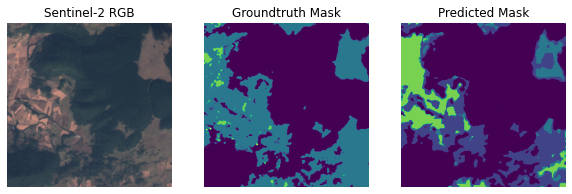

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


train_acc_segmentation,▁▅▆▆▆▇▇▇██
train_iou_segmentation,▁▄▅▅▆▆▇▇▇█
train_loss_segmentation,█▄▃▃▃▂▂▂▁▁
val_acc_segmentation,▁▄▄▆▆▅█▇▇▆
val_iou_segmentation,▁▅▄▅▆▆█▇▇▇
val_loss_segmentation,█▃▃▂▂▃▁▁▂▃
train_acc_segmentation,0.81522
train_iou_segmentation,0.43144
train_loss_segmentation,0.50258
val_acc_segmentation,0.76737
val_iou_segmentation,0.40047


Validation Loss: 0.7059: 100%|██████████| 129/129 [00:15<00:00,  8.17it/s]

train_iou is 0.2666, val_iou is 0.3452
train_acc is 0.6552, val_acc is 0.7395



Validation Loss: 0.6646: 100%|██████████| 129/129 [00:15<00:00,  8.10it/s]


Saving Model...
train_iou is 0.3385, val_iou is 0.3597
train_acc is 0.7409, val_acc is 0.7580


Validation Loss: 0.5872: 100%|██████████| 129/129 [00:15<00:00,  8.17it/s]


Saving Model...
train_iou is 0.3683, val_iou is 0.3849
train_acc is 0.7668, val_acc is 0.7901


Validation Loss: 0.5966: 100%|██████████| 129/129 [00:15<00:00,  8.17it/s]

train_iou is 0.3919, val_iou is 0.4026
train_acc is 0.7864, val_acc is 0.7863



Validation Loss: 0.5233: 100%|██████████| 129/129 [00:15<00:00,  8.15it/s]


Saving Model...
train_iou is 0.4085, val_iou is 0.4075
train_acc is 0.8027, val_acc is 0.8097


Validation Loss: 0.4905: 100%|██████████| 129/129 [00:15<00:00,  8.17it/s]


Saving Model...
train_iou is 0.4274, val_iou is 0.4450
train_acc is 0.8163, val_acc is 0.8213


Validation Loss: 0.4424: 100%|██████████| 129/129 [00:15<00:00,  8.16it/s]


Saving Model...
train_iou is 0.4433, val_iou is 0.4525
train_acc is 0.8251, val_acc is 0.8411


Validation Loss: 0.4453: 100%|██████████| 129/129 [00:15<00:00,  8.17it/s]

train_iou is 0.4521, val_iou is 0.4455
train_acc is 0.8315, val_acc is 0.8349



Validation Loss: 0.4283: 100%|██████████| 129/129 [00:15<00:00,  8.15it/s]


Saving Model...
train_iou is 0.4601, val_iou is 0.4580
train_acc is 0.8382, val_acc is 0.8434


Validation Loss: 0.4200: 100%|██████████| 129/129 [00:15<00:00,  8.13it/s]


Saving Model...
train_iou is 0.4705, val_iou is 0.4739
train_acc is 0.8441, val_acc is 0.8466
Finished Training


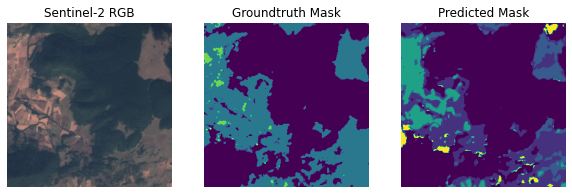

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


train_acc_segmentation,▁▄▅▆▆▇▇███
train_iou_segmentation,▁▃▄▅▆▇▇▇██
train_loss_segmentation,█▅▄▃▃▂▂▁▁▁
val_acc_segmentation,▁▂▄▄▆▆█▇██
val_iou_segmentation,▁▂▃▄▄▆▇▆▇█
val_loss_segmentation,█▇▅▅▄▃▂▂▁▁
train_acc_segmentation,0.84413
train_iou_segmentation,0.47053
train_loss_segmentation,0.42553
val_acc_segmentation,0.84656
val_iou_segmentation,0.47395


Validation Loss: 0.7036: 100%|██████████| 129/129 [00:15<00:00,  8.17it/s]

train_iou is 0.2799, val_iou is 0.3184
train_acc is 0.6724, val_acc is 0.7434



Validation Loss: 0.6089: 100%|██████████| 129/129 [00:15<00:00,  8.12it/s]


Saving Model...
train_iou is 0.3443, val_iou is 0.3750
train_acc is 0.7472, val_acc is 0.7823


Validation Loss: 0.5928: 100%|██████████| 129/129 [00:15<00:00,  8.16it/s]


Saving Model...
train_iou is 0.3621, val_iou is 0.3900
train_acc is 0.7645, val_acc is 0.7890


Validation Loss: 0.5704: 100%|██████████| 129/129 [00:15<00:00,  8.16it/s]


Saving Model...
train_iou is 0.3779, val_iou is 0.3987
train_acc is 0.7762, val_acc is 0.7978


Validation Loss: 0.5250: 100%|██████████| 129/129 [00:15<00:00,  8.16it/s]


Saving Model...
train_iou is 0.3904, val_iou is 0.4166
train_acc is 0.7854, val_acc is 0.8113


Validation Loss: 0.5251: 100%|██████████| 129/129 [00:15<00:00,  8.17it/s]

train_iou is 0.4090, val_iou is 0.4153
train_acc is 0.7990, val_acc is 0.8112



Validation Loss: 0.4880: 100%|██████████| 129/129 [00:15<00:00,  8.15it/s]


Saving Model...
train_iou is 0.4185, val_iou is 0.4235
train_acc is 0.8089, val_acc is 0.8213


Validation Loss: 0.4665: 100%|██████████| 129/129 [00:15<00:00,  8.17it/s]


Saving Model...
train_iou is 0.4236, val_iou is 0.4452
train_acc is 0.8129, val_acc is 0.8308


Validation Loss: 0.4689: 100%|██████████| 129/129 [00:15<00:00,  8.17it/s]

train_iou is 0.4377, val_iou is 0.4350
train_acc is 0.8205, val_acc is 0.8284



Validation Loss: 0.4508: 100%|██████████| 129/129 [00:15<00:00,  8.16it/s]


Saving Model...
train_iou is 0.4447, val_iou is 0.4547
train_acc is 0.8262, val_acc is 0.8348
Finished Training


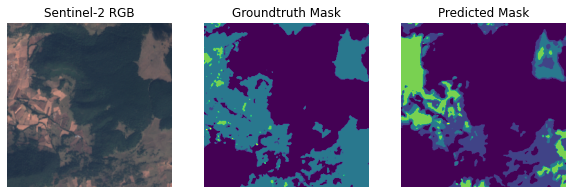

In [34]:
for filename in check_point_paths:
    # Update checkpoint name
    train_config.checkpoint_name = filename
    # Load Encoder from different pre-text architectures
    encoder = load_encoder_checkpoint_from_pretext_model(
        path_to_checkpoint=filename,
    )
    patch_first_conv(encoder,13,default_in_channels=3)

    # freeze layers
    if train_config.frozen == True:
        for param in encoder.parameters():
          param.requires_grad = False

    model_name = filename.split("/")[-1].split(".")[0]
    model_dir = '/content/drive/My Drive/deep_learning_segmentation_checkpoints'
    model_path = os.path.join(model_dir,f'segmentation_{model_name}.ckpt')
    # make sure the directory path exists
    assert os.path.exists(model_dir)
    

    wandb.init(
        project="ssl-remote-sensing-segmentation-dfc-frozen",
        name=model_name,
        config=train_config.__dict__,
    )

    # Model setup
    if "bigan" in train_config.checkpoint_name.lower():
        model = ResNetUNet(9,encoder = encoder, gan_encoder=True)
    else:
        model = ResNetUNet(9, encoder = encoder, gan_encoder=False)
    
    # train(model)
    train(model,train_config,train_loader,val_loader,loss_fn,device,model_path,wandb = wandb)
    
    # Initialise a UNet() model 
    if "bigan" in train_config.checkpoint_name.lower():
        bst_model = ResNetUNet(9,encoder = encoder, gan_encoder=True)
    else:
        bst_model = ResNetUNet(9, encoder = encoder, gan_encoder=False)
    # # Load pretrained weights
    bst_model.load_state_dict(torch.load(model_path))
    # # Move to device (GPU or CPU)
    bst_model.to(device)
    # visualize_result(171,bst_model)
    visualize_result(171,bst_model,valset,device,wandb = wandb,model_name = model_name)